<b>Data analysis experiment 1</b>

We first need to create the dataset. It is extracted from a csv that has been generated from the row data. 

We have two ways to discriminate the performance of our subjects : their coherent trials and their audibility measurements. 

First, we want to select participants that have above x% correct answers at coherent trials.

For that we chose a critical score below which the participant is excluded :

In [4]:
score_crit=80

In [5]:
#Create the dataset we need

import numpy as np
import csv
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

#Data recollection
file = open('C:\\Users\\Rodrigue\\Documents\\Rodrigue\\Revcor_fsd\\revcor_fsd\\data\\Donnees_premiere_session.csv')

with open('C:\\Users\\Rodrigue\\Documents\\Rodrigue\\Revcor_fsd\\revcor_fsd\\data\\Donnees_premiere_session.csv') as file:
    file_read = csv.reader(file)
    data = list(file_read)

x=np.linspace(1,7,7)
subjects=np.zeros(99)
weights=np.zeros((99,7))
audibilities=np.zeros((99,7))
coherents=np.zeros(99)
for i in range(1,100):
    subjects[i-1]=data[i][0]
    weights[i-1]=data[i][1:8]
    audibilities[i-1]=data[i][8:15]
    coherents[i-1]=data[i][15]
    
    
#Remove participants with less than x% score at coherents
index_c=np.where(coherents>score_crit)
good_subjects=np.zeros(len(index_c[0]))
good_weights=np.zeros((len(index_c[0]),7))
good_coherents=np.zeros(len(index_c[0]))
good_audibilities=np.zeros((len(index_c[0]),7))
for i in range(len(index_c[0])):
    good_subjects[i]=subjects[index_c[0][i]]
    good_weights[i]=weights[index_c[0][i]]
    good_coherents[i]=coherents[index_c[0][i]]
    good_audibilities[i]=audibilities[index_c[0][i]]

#Sort by increasing coherent score
perf=np.argsort(good_coherents)

good_subjects=np.array(good_subjects)[perf]
good_weights=np.array(good_weights)[perf]
good_coherents=np.array(good_coherents)[perf]
good_audibilities=np.array(good_audibilities)[perf]

We can then reject the participants that show some audibility measurement below a certain attenuation threshold.

In [6]:
audi_min=-20

In [7]:
#Sort via Audibility
#We want to cut participants which have some attenuations under x dB

index_a=np.where(np.all(good_audibilities<audi_min, axis=1))
very_good_subjects=np.zeros(len(index_a[0]))
very_good_weights=np.zeros((len(index_a[0]),7))
very_good_coherents=np.zeros(len(index_a[0]))
very_good_audibilities=np.zeros((len(index_a[0]),7))
for i in range(len(index_a[0])):
    very_good_subjects[i]=good_subjects[index_a[0][i]]
    very_good_weights[i]=good_weights[index_a[0][i]]
    very_good_coherents[i]=good_coherents[index_a[0][i]]
    very_good_audibilities[i]=good_audibilities[index_a[0][i]]

Here we can plot the weights of the remaining participants for a first visualisation.

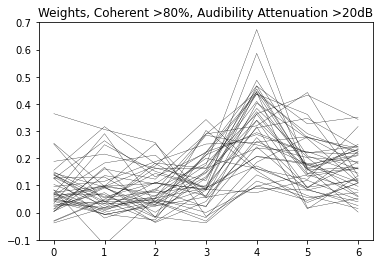

In [8]:
#Plot the weights

plt.title(f'Weights, Coherent >{score_crit}%, Audibility Attenuation >{-audi_min}dB')
plt.ylim(-0.1,0.7)
for i in range(len(very_good_weights)):
    plt.plot(very_good_weights[i], '-k', linewidth=0.3)
plt.show()

One way to analyse the data is to try to reduce the dimensionality of our weights distribution, for instance through PCA. Here, we compute n dimensions, and we give their explained variance ratio. 

In [9]:
n_dimensions=2

Explained variance : [0.36254921 0.18557316]


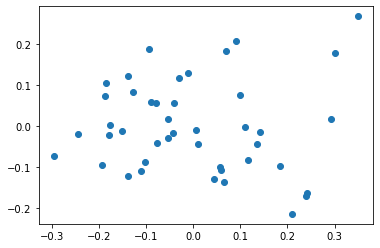

In [10]:
#PCA

from sklearn import decomposition

pca = decomposition.PCA(n_components=n_dimensions)
PrincipalComponents=pca.fit_transform(very_good_weights)


plt.scatter(PrincipalComponents[:,0],PrincipalComponents[:,1])
print('Explained variance :', pca.explained_variance_ratio_)

plt.show()

Now what we would want is to seperate the subjects in groups of similar weights profile. That can be done through clustering algorithm. Here we propose to explore two of them : the standard k-means algorithm, or an agglomerative hierarchical algorithm. 

In [11]:
n_clusters=4
cluster_type = 'k-means'
#Choices are k-means or agglo

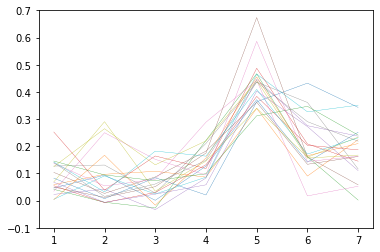

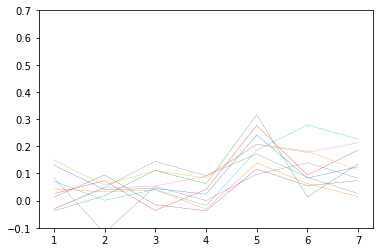

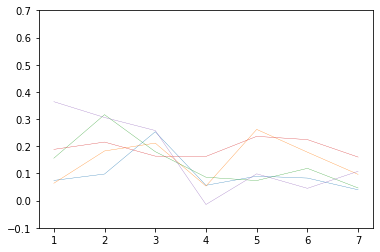

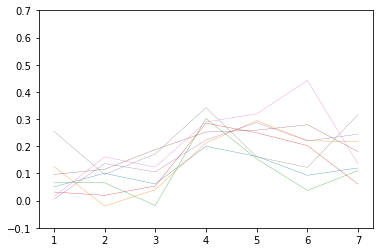

In [12]:
#Cluster algorithm

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

#cluster algorithm type
if cluster_type=='k-means':
    model = KMeans(n_clusters=n_clusters)
    model.fit(very_good_weights)
    yhat = model.predict(very_good_weights)
elif cluster_type=='agglo':
    model = AgglomerativeClustering(n_clusters=n_clusters)
    yhat = model.fit_predict(weights)
else:
    print('not a correct cluster type')

# retrieve unique clusters
clusters = np.unique(yhat)

# create arrays and plot for each clusters
Subjects=[]
Weights=[]
Coherents=[]
Audibilities=[]
for cluster in clusters:
    # get row indexes for samples with this cluster
    plt.figure()
    row_ix = np.where(yhat == cluster)
    weights_cluster=np.zeros((len(row_ix[0]),7))
    subjects_cluster=np.zeros(len(row_ix[0]))
    coherents_cluster=np.zeros(len(row_ix[0]))
    audibilities_cluster=np.zeros((len(row_ix[0]),7))
    for k in range(len(row_ix[0])):
        weights_cluster[k]=very_good_weights[row_ix[0][k]]
        subjects_cluster[k]=int(very_good_subjects[row_ix[0][k]])
        coherents_cluster[k]=very_good_coherents[row_ix[0][k]]
        audibilities_cluster[k]=very_good_audibilities[row_ix[0][k]]
        
        plt.ylim(-0.1,0.7)
        plt.plot(x,weights_cluster[k],'-', linewidth=0.3)
    Subjects.append(subjects_cluster)
    Weights.append(weights_cluster)
    Coherents.append(coherents_cluster)
    Audibilities.append(audibilities_cluster)
# show the plot
plt.show()

One idea to select participants would be to take the x participants with the best scores in each cluster, to keep noth variety and quality. It will however lead us to overestimate the inter-individual variation across all clusters. 

In [13]:
n_per_clusters=5

In [14]:
Subjects_final=[]
Weights_final=[]
Coherents_final=[]
Audibilities_final=[]

for i in range(len(clusters)):
    Subjects_final.append(Subjects[i][-n_per_clusters:len(Subjects[i])])
    Weights_final.append(Weights[i][-n_per_clusters:len(Subjects[i])])
    Coherents_final.append(Audibilities[i][-n_per_clusters:len(Subjects[i])])
    Audibilities_final.append(Audibilities[i][-n_per_clusters:len(Audibilities[i])])

In [15]:
Subjects_final

[array([23., 45., 96., 41., 30.]),
 array([ 2., 21., 54., 11., 92.]),
 array([28., 67.,  8., 73., 24.]),
 array([50., 13., 25., 70., 61.])]

We can plot these subjects only, in their respective clusters.

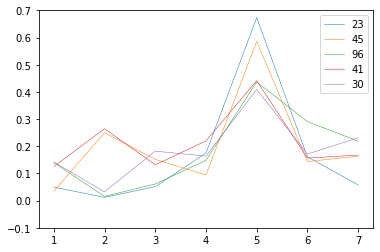

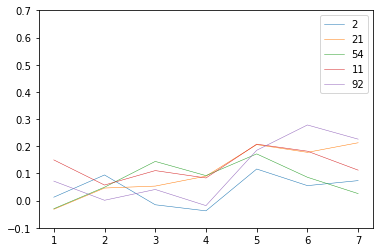

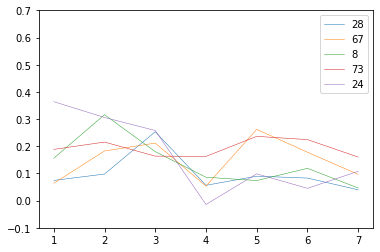

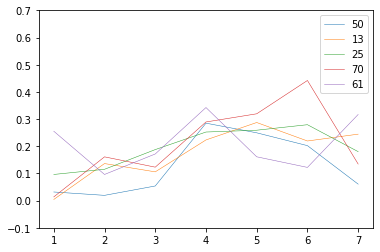

In [18]:
for i in range(len(clusters)):
    plt.figure()
    plt.ylim(-0.1,0.7)
    for k in range(len(Subjects_final[i])):
        plt.plot(x,Weights_final[i][k],'-', linewidth=0.5,label=int(Subjects_final[i][k]))
        plt.legend()
plt.show()

One interesting thing to look at would be the correlation between the audibility of each subject and their weights distribution. (We may go back to taking all participants in each clusters).

We can first visualise these audibilities in each cluster. 

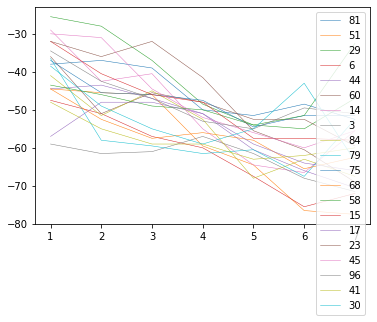

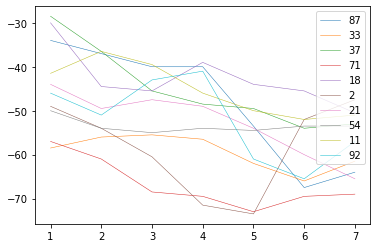

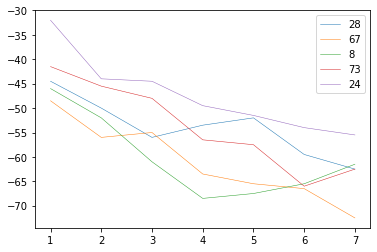

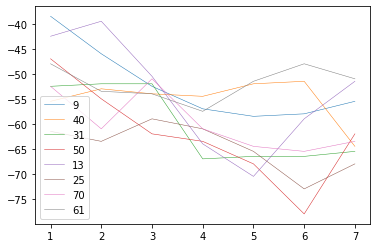

In [80]:
for i in clusters:
    plt.figure()
    for k in range(len(Subjects[i])):
        plt.plot(x,Audibilities[i][k], linewidth='0.5', label=int(Subjects[i][k]))
    plt.legend()
plt.show()

Now we can look at the correlation. We can look at Pearson and Spearman correlations.

In [57]:
#Uncomment the correlation type, p is pearson ans s is spearman

corr_type='p'
#corr_type='s'

In [63]:
from scipy import stats

corr_mean=np.zeros(len(clusters))

for i in clusters:
    corr=0
    for k in range(len(Subjects[i])):
        if corr_type=='p':
            corr+=-stats.pearsonr(Weights[i][k],Audibilities[i][k])[0]
        elif corr_type=='s':
            corr+=-stats.spearmanr(Weights[i][k],Audibilities[i][k])[0]
    corr=corr/len(Subjects[i])
    corr_mean[i]=corr

Here we can look at the mean correlation in each cluster.

In [61]:
print('Cluster 1 :', round(corr_mean[0],3), '; Cluster 2 :', round(corr_mean[1],3), '; Cluster 3 :', round(corr_mean[2],3), '; Cluster 4 :', round(corr_mean[3],3))

Cluster 1 : 0.469 ; Cluster 2 : 0.497 ; Cluster 3 : -0.247 ; Cluster 4 : 0.541


We find a pretty high correlation value for clusters 1, 2 and 4, which is not that surprising because the audibility is generally increasing with frequency, and so are our weights in average. However, it cannot explain the third cluster, as it shows a negative correlation this time. 

Indeed, we could look at the variance of audibilities intra and inter cluster, to see if it could explain their existence. (not sure about how to do it exactly). 

In [95]:
intra_var_audi=np.zeros(len(clusters))
intra_mean_audi=np.zeros((len(clusters),7))
for i in clusters:
    intra_var_audi[i]=np.var(Audibilities[i])
    intra_mean_audi[i]=np.mean(Audibilities[i], axis=0)
total_var_audi=np.var(very_good_audibilities)
print(np.mean(intra_var_audi))
print(total_var_audi)


92.20926977040817
104.64809991059701


If we did the same for weights, we get :

In [94]:
intra_var_w=np.zeros(len(clusters))
intra_mean_w=np.zeros((len(clusters),7))
for i in clusters:
    intra_var_w[i]=np.var(Weights[i])
    intra_mean_w[i]=np.mean(Weights[i], axis=0)
total_var_w=np.var(very_good_weights)
print(np.mean(intra_var_w))
print(total_var_w)


0.011467288053819113
0.015158759729862055


We can try to look at the so called cluster scatter.  

In [109]:
#Scatter weights
cluster_scatter=np.zeros(7)
for i in clusters:
    for k in range(len(Subjects[i])):
        cluster_scatter+=(Weights[i][k]-np.mean(Weights[i], axis=0))**2
scatter_c=np.mean(cluster_scatter)
print(scatter_c)

total_scatter=np.zeros(7)
for i in clusters:
    for k in range(len(Subjects[i])):
        cluster_scatter+=(Weights[i][k]-np.mean(very_good_weights[i], axis=0))**2
scatter_t=np.mean(cluster_scatter)
print(scatter_t)

0.23310494985549793
0.9046465896150566


In [110]:
#Scatter Audibility
cluster_scatter=np.zeros(7)
for i in clusters:
    for k in range(len(Subjects[i])):
        cluster_scatter+=(Audibilities[i][k]-np.mean(Audibilities[i], axis=0))**2
scatter_c=np.mean(cluster_scatter)
print(scatter_c)

total_scatter=np.zeros(7)
for i in clusters:
    for k in range(len(Subjects[i])):
        cluster_scatter+=(Audibilities[i][k]-np.mean(very_good_audibilities[i], axis=0))**2
scatter_t=np.mean(cluster_scatter)
print(scatter_t)

2567.4160714285713
8277.278316326532


<b>Problem : we find that the variance between cluster is also lower than the variance within cluster for audibility. </b>